In [14]:
import os
import locale
from enum import Enum
import datetime as dt

import pandas as pd 
import numpy as np 

from matplotlib import pyplot as plt 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib.dates import DateFormatter, MinuteLocator, DayLocator

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec


locale.setlocale(locale.LC_ALL, 'it_IT.UTF-8')
#locale.setlocale(locale.LC_ALL, '')


'it_IT.UTF-8'

In [2]:
# Daily deaths toll.
daily_data_file_path = os.path.join("..","data", "Istat", "dati-giornalieri-comune")
daily_data_file_name = "comune_giorno.csv"
daily_file = os.path.join(daily_data_file_path, daily_data_file_name)




In [39]:
#
# Data file reading.
#
dtype_dict = {
    "PROV":"object"
   ,"REG":"object"
   ,"GE":"object"
   ,"CL_ETA":"object"
}

daily_df = pd.read_csv(daily_file, sep=',', lineterminator='\n',low_memory=False, encoding='latin-1',dtype=dtype_dict)

#daily_df.set_index(["NOME_PROVINCIA","NOME_COMUNE"], inplace = True)

daily_df.rename(columns={"TOTALE_20\r": "TOTALE_20"}, inplace=True)

# Unpack the MONTHDAY column in two separate colums.
daily_df["Month"] = daily_df["GE"].apply(lambda row : row[0:2])
daily_df["Day"] = daily_df["GE"].apply(lambda row : row[-2:])

daily_df['dateTime'] =  pd.to_datetime("2020/" + daily_df['Month']+ "/" +daily_df['Day'], format='%Y/%m/%d')
daily_df.set_index(["dateTime"], inplace=True)
daily_df.sort_index(inplace=True)


(daily_df.shape, daily_df.dtypes)

((849120, 29),
 REG                 object
 PROV                object
 NOME_REGIONE        object
 NOME_PROVINCIA      object
 NOME_COMUNE         object
 COD_PROVCOM          int64
 DATA_INIZIO_DIFF    object
 CL_ETA              object
 GE                  object
 MASCHI_15            int64
 MASCHI_16            int64
 MASCHI_17            int64
 MASCHI_18            int64
 MASCHI_19            int64
 MASCHI_20            int64
 FEMMINE_15           int64
 FEMMINE_16           int64
 FEMMINE_17           int64
 FEMMINE_18           int64
 FEMMINE_19           int64
 FEMMINE_20           int64
 TOTALE_15            int64
 TOTALE_16            int64
 TOTALE_17            int64
 TOTALE_18            int64
 TOTALE_19            int64
 TOTALE_20            int64
 Month               object
 Day                 object
 dtype: object)

In [40]:
daily_df.head(3)

,REG,PROV,NOME_REGIONE,NOME_PROVINCIA,NOME_COMUNE,COD_PROVCOM,DATA_INIZIO_DIFF,CL_ETA,GE,MASCHI_15,...,FEMMINE_19,FEMMINE_20,TOTALE_15,TOTALE_16,TOTALE_17,TOTALE_18,TOTALE_19,TOTALE_20,Month,Day
dateTime,,,,,,,,,,,,,,,,,,,,,
2020-01-01,07,010,Liguria,Genova,Recco,10047,16 aprile,17,0101,0,...,0,0,0,0,1,0,0,0,01,01
2020-01-01,16,075,Puglia,Lecce,Melissano,75044,Dati 2020 n.d.,18,0101,0,...,0,9999,0,0,0,1,0,9999,01,01
2020-01-01,05,028,Veneto,Padova,Battaglia Terme,28011,1 aprile,16,0101,0,...,0,0,0,0,0,1,0,0,01,01


In [66]:
# ------------------------------------------------------------
# ------------------------------------------------------------
# Some common functions.
# ------------------------------------------------------------
# ------------------------------------------------------------
def remove_tick_lines(which, ax):
    if which == 'y':
        for line in ax.yaxis.get_majorticklines():
            line.set_visible(False)
    elif which == 'x':
        for line in ax.xaxis.get_majorticklines():
            line.set_visible(False)
    else:
        assert False, "Wrong axis parameter."

def every_nth_tick(ax, every_nth = 2):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

def autolabel(rects, ax, dec_no=0):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + (height * 0.01),
                '%s' % round(height, dec_no),
                ha='center', va='bottom')

def set_axes_common_properties(axe, no_grid=False, border=False):
    rv = 1
    try:
        axe.spines['top'].set_visible(border)
        axe.spines['left'].set_visible(border)
        axe.spines['right'].set_visible(border)
        axe.spines['bottom'].set_visible(border)
        if no_grid == False:
            axe.grid(color='#636262', linestyle='-.', linewidth=0.2)
        rv = 0
    except Exception as ex:
        print("Errore - {e}".format(e=str(ex)))
        
    return rv

def text_box(ax, text, colors=["#FFFFFF", "#000000"], fontsize=14, x=0, y=0):
    """
    """
    rv = False
    try:
        edgecolor = "none"
        boxstyle = "square"
        if len(colors) >= 3 and colors[2] is not None:
            edgecolor = colors[2]
            boxstyle = "round,pad=1"
        ax.text(x, y
               ,text
               ,ha="left", va="center" 
               ,bbox=dict(boxstyle = boxstyle, facecolor = colors[0], edgecolor = edgecolor)
               ,color=colors[1]
               ,fontsize=fontsize)
        set_axes_common_properties(ax, no_grid=True)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
    except Exception as ex:
        print("text_box failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv   

#----------------------------------------------------------------
# Common chart function.
#----------------------------------------------------------------
def composed_chart(ax, data_sets,log=False, title=None):
    """
    
    :param ax:
    :param data_sts: dictionary containing all the data set 
                     parameters to customize a single plot;
    :param log:
    :param title:
    :return:
    """
    rv = False
    try:
        set_axes_common_properties(ax, no_grid=False)
        #ax.set_xlim(time_limits)

        max_y = None
        for key in data_sets.keys():
            df = data_sets[key]["df"]
            
            if data_sets[key].get("time column") is not None:
                col_name = data_sets[key]["time column"]
                x = df[col_name].dt.to_pydatetime()
            else:
                assert False, "Time column not given."
                
            if data_sets[key].get("value column") is not None:
                col_name = data_sets[key]["value column"]
                y = df[col_name]
            else:
                assert False, "Value column not given."
                
            new_max = y.max()
            if max_y is None or new_max > max_y:
                max_y = new_max
                
            colors = data_sets[key]["colors"]

            time_limits = [x.min() - pd.Timedelta(hours=7) 
                          ,x.max() + pd.Timedelta(hours=7)]
            ax.set_xlim(time_limits)
            
            ax.scatter(x, y, color=colors[0], s=data_sets[key]["size"], marker=data_sets[key]["dot-shape"], label=data_sets[key]["label"])
            if data_sets[key]["no_plot"] == False:
                ax.plot(x, y, 'b-', linewidth=data_sets[key]["line-size"], color=colors[1])
        
        if title is not None:
            ax.set_title(title, fontsize=16)
        
        ax.set_ylim(top=max_y + 1000)
        
        ax.set_ylabel("Numero", fontsize=12)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
       
        ax.tick_params(axis='x', labelrotation=80)
        remove_tick_lines('x', ax)
        
        # 'upper left' - 'upper right' - 'lower right'
        ax.legend(fontsize=12, loc='upper left')
            
    except Exception as ex:
        print("composed_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv

def make_weekly_df(df, province, city, value_col_name):
    rv = False
    x = None
    y = None
    try:
        min_dt = daily_df.index.min()
        max_dt = daily_df.index.max()
        
        df = daily_df.loc[min_dt : pd.to_datetime("2020/04/01", format='%Y/%m/%d')]

        mask = (df["NOME_PROVINCIA"] == province) & (df["NOME_COMUNE"] == city) 
        df = df[mask]
        df = df[value_col_name].resample('W').sum().to_frame()
        df.reset_index(inplace=True)
        x = df['dateTime'].dt.to_pydatetime()
        y = df[value_col_name].values
               
    except Exception as ex:
        print("make_weekly_df failed - {ex}".format(ex=ex))
    else:
        rv = True  
    return (rv, x, y, df)
    

[Text(0, 0, '05/01'),
 Text(0, 0, '12/01'),
 Text(0, 0, '19/01'),
 Text(0, 0, '26/01'),
 Text(0, 0, '02/02'),
 Text(0, 0, '09/02'),
 Text(0, 0, '16/02'),
 Text(0, 0, '23/02'),
 Text(0, 0, '01/03'),
 Text(0, 0, '08/03')]

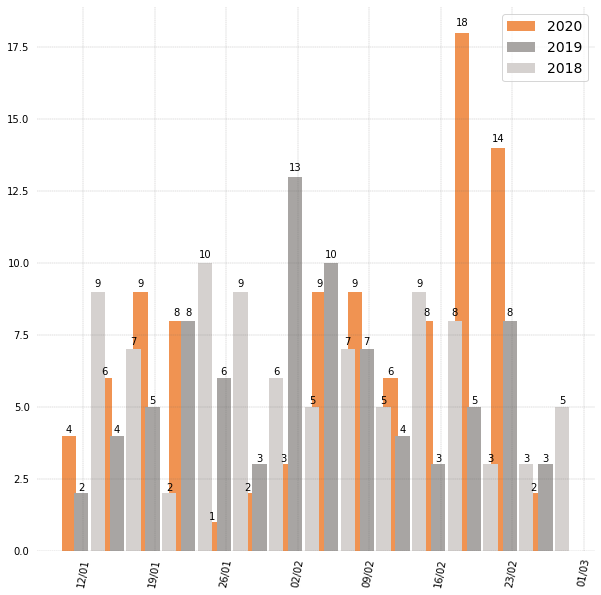

In [118]:
province = "Milano"
city = "Segrate"

result, x_20, y_20, df = make_weekly_df(daily_df, province, city, "TOTALE_20")
result, x_19, y_19, df = make_weekly_df(daily_df, province, city, "TOTALE_19")
result, x_18, y_18, df = make_weekly_df(daily_df, province, city, "TOTALE_18")

x_20 = [ d.strftime("%d/%m") for d in x_20]
x_19 = [ d.strftime("%d/%m") for d in x_19]
x_18 = [ d.strftime("%d/%m") for d in x_18]

assert x_20 == x_19, "Date array different."
assert x_20 == x_18, "Date array different."


fig = plt.figure(figsize=(10, 10))
gs1 = gridspec.GridSpec(1, 1
                       ,figure=fig)

ax = []
ax.append(fig.add_subplot(gs1[0,0]))
idx = 0

set_axes_common_properties(ax[idx])
remove_tick_lines('y', ax[idx])
remove_tick_lines('x', ax[idx])

bar_num = 3
width = 0.4
bar_space = width/3

x_idx = np.asarray([i for i in range(len(x))])

rects_20 = ax[idx].bar(x_idx - (bar_space + 2*bar_space), y_20, color="#f09352", width=width, label='2020')
rects_19 = ax[idx].bar(x_idx - (bar_space/2),           y_19, color="#a8a5a3", width=width, label='2019')
rects_18 = ax[idx].bar(x_idx + (bar_space + 2*bar_space), y_18, color="#d5d1cf", width=width, label='2018')

autolabel(rects_20, ax[idx], 1)
autolabel(rects_19, ax[idx], 1)
autolabel(rects_18, ax[idx], 1)

ax[idx].legend(fontsize=14)
ax[idx].set_xticklabels(x, rotation=80)



In [105]:
result, x_20, y_20, df_20 = make_weekly_df(daily_df, province, city, "TOTALE_20")

(result, x_20, y_20, df_20)

(True,
 array([datetime.datetime(2020, 1, 5, 0, 0),
        datetime.datetime(2020, 1, 12, 0, 0),
        datetime.datetime(2020, 1, 19, 0, 0),
        datetime.datetime(2020, 1, 26, 0, 0),
        datetime.datetime(2020, 2, 2, 0, 0),
        datetime.datetime(2020, 2, 9, 0, 0),
        datetime.datetime(2020, 2, 16, 0, 0),
        datetime.datetime(2020, 2, 23, 0, 0),
        datetime.datetime(2020, 3, 1, 0, 0),
        datetime.datetime(2020, 3, 8, 0, 0),
        datetime.datetime(2020, 3, 15, 0, 0),
        datetime.datetime(2020, 3, 22, 0, 0),
        datetime.datetime(2020, 3, 29, 0, 0),
        datetime.datetime(2020, 4, 5, 0, 0)], dtype=object),
 array([ 4,  6,  9,  8,  1,  2,  3,  9,  9,  6,  8, 18, 14,  2]),
      dateTime  TOTALE_20
 0  2020-01-05          4
 1  2020-01-12          6
 2  2020-01-19          9
 3  2020-01-26          8
 4  2020-02-02          1
 5  2020-02-09          2
 6  2020-02-16          3
 7  2020-02-23          9
 8  2020-03-01          9
 9  2020-03-0

In [106]:
result, x_19, y_19, df_19 = make_weekly_df(daily_df, province, city, "TOTALE_19")
(df_20, df_19)

(     dateTime  TOTALE_20
 0  2020-01-05          4
 1  2020-01-12          6
 2  2020-01-19          9
 3  2020-01-26          8
 4  2020-02-02          1
 5  2020-02-09          2
 6  2020-02-16          3
 7  2020-02-23          9
 8  2020-03-01          9
 9  2020-03-08          6
 10 2020-03-15          8
 11 2020-03-22         18
 12 2020-03-29         14
 13 2020-04-05          2,
      dateTime  TOTALE_19
 0  2020-01-05          2
 1  2020-01-12          4
 2  2020-01-19          5
 3  2020-01-26          8
 4  2020-02-02          6
 5  2020-02-09          3
 6  2020-02-16         13
 7  2020-02-23         10
 8  2020-03-01          7
 9  2020-03-08          4
 10 2020-03-15          3
 11 2020-03-22          5
 12 2020-03-29          8
 13 2020-04-05          3)

In [107]:
x_20 = [ d.strftime("%d/%m") for d in x_20]
x_19 = [ d.strftime("%d/%m") for d in x_19]

In [102]:
x_20[3] = "pollo"

In [108]:
x_20 == x_19

True